In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical

from utils.model import PPO
from utils.replaybuffer import RolloutBuffer
from utils.AI_Interface import *
from utils.reward import *
from utils.action_transform import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim,
                 fStickLat_shape, fStickLon_shape,
                 fThrottle_shape, fRudder_shape, eEleScanLine_shape,
                 eAziScanRange, WeaponLaunch):
        super(ActorCritic, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # actor
        self.actor1 = nn.Linear(64, fStickLat_shape)
        self.actor2 = nn.Linear(64, fStickLon_shape)
        self.actor3 = nn.Linear(64, fThrottle_shape)
        self.actor4 = nn.Linear(64, fRudder_shape)
        self.actor5 = nn.Linear(64, eEleScanLine_shape)
        self.actor6 = nn.Linear(64, eAziScanRange)
        self.actor7 = nn.Linear(64, WeaponLaunch)
        self.softmax = nn.Softmax(1)

        # critic
        self.critic = nn.Linear(64, 1)

    def forward(self, state):
        x = self.fc(state)
        output1 = self.softmax(self.actor1(x))
        output2 = self.softmax(self.actor2(x))
        output3 = self.softmax(self.actor3(x))
        output4 = self.softmax(self.actor4(x))
        output5 = self.softmax(self.actor5(x))
        output6 = self.softmax(self.actor6(x))
        output7 = self.softmax(self.actor7(x))

        return output1, output2, output3, output4, output5, output6, output7

    def act(self, state):
        action_probs = []
        x = self.fc(state)
        action_probs.append(self.softmax((self.actor1(x))))
        action_probs.append(self.softmax((self.actor2(x))))
        action_probs.append(self.softmax((self.actor3(x))))
        action_probs.append(self.softmax((self.actor4(x))))
        action_probs.append(self.softmax((self.actor5(x))))
        action_probs.append(self.softmax((self.actor6(x))))
        action_probs.append(self.softmax((self.actor7(x))))

        dist = []
        for i in range(len(action_probs)):
            dist.append(Categorical(action_probs[i]))

        action = []
        for i in range(len(action_probs)):
            action.append(dist[i].sample())

        for i in range(len(action_probs)):
            if i == 0:
                action_logprob = dist[i].log_prob(action[i]).unsqueeze(0)
            else:
                action_logprob = torch.cat([action_logprob, dist[i].log_prob(action[i]).unsqueeze(0)], 0)

        return action.detach(), action_logprob.detach()

    def evaluate(self, state, action):
        action_probs = []
        x = self.fc(state)
        action_probs.append(self.softmax((self.actor1(x))))
        action_probs.append(self.softmax((self.actor2(x))))
        action_probs.append(self.softmax((self.actor3(x))))
        action_probs.append(self.softmax((self.actor4(x))))
        action_probs.append(self.softmax((self.actor5(x))))
        action_probs.append(self.softmax((self.actor6(x))))
        action_probs.append(self.softmax((self.actor7(x))))

        dist = []
        for i in range(len(action_probs)):
            dist.append(Categorical(action_probs[i]))

        for i in range(len(action_probs)):
            if i == 0:
                action_logprobs = dist[i].log_prob(action[:, i]).unsqueeze(1)
            else:
                action_logprobs = torch.cat([action_logprobs, dist[i].log_prob(action[:, i]).unsqueeze(1)], 1)

        for i in range(len(action_probs)):
            if i == 0:
                dist_entropy = dist[i].entropy().unsqueeze(1)
            else:
                dist_entropy = torch.cat([dist_entropy, dist[i].entropy().unsqueeze(1)], 1)

        state_values = self.critic(self.fc(state))

        return action_logprobs, state_values, dist_entropy

In [3]:
state_dim = 426 # 不带id和timestamp
action_dim = 8
lr_actor = 0.0003
lr_critic = 0.001 
gamma = 0.99
# K_epochs = 1
K_epochs = 80
eps_clip = 0.2

fStickLat_shape=5
fStickLon_shape=5
fThrottle_shape=3
fRudder_shape=5
eEleScanLine_shape=2
eAziScanRange=3
WeaponLaunch=2

In [4]:
agent = PPO(state_dim,
            fStickLat_shape, fStickLon_shape,
            fThrottle_shape, fRudder_shape,
            eEleScanLine_shape, eAziScanRange, WeaponLaunch, 
            lr_actor, lr_critic, gamma, K_epochs, eps_clip)

agent.policy = ActorCritic(state_dim,
                   fStickLat_shape, fStickLon_shape,
                 fThrottle_shape, fRudder_shape,eEleScanLine_shape,
                 eAziScanRange, WeaponLaunch).to(device)

agent.optimizer = torch.optim.Adam([
                {'params': agent.policy.fc.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor1.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor2.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor3.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor4.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor5.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor6.parameters(), 'lr': lr_actor},
                {'params': agent.policy.actor7.parameters(), 'lr': lr_actor},
                {'params': agent.policy.critic.parameters(), 'lr': lr_critic}
            ])

agent.old_policy = ActorCritic(state_dim,
           fStickLat_shape, fStickLon_shape,
         fThrottle_shape, fRudder_shape, eEleScanLine_shape,
         eAziScanRange, WeaponLaunch).to(device)

agent.old_policy.load_state_dict(agent.policy.state_dict())

if os.path.exists('checkpoint/ppo.pt'):
    agent.load('checkpoint/ppo.pt')

In [5]:
data = pd.read_csv('../data',header=None,nrows=1000)

# 有可能会给到双方的数据，也可能是单方的
if data[0].nunique()>1:
    red_data = data[data[0]==data[0].unique()[0]].reset_index(drop=True)
    blue_data = data[data[0]==data[0].unique()[1]].reset_index(drop=True)
else:
    red_data = data

# 只使用一方数据进行训练
i = 1
while i < (len(red_data)-1):
    # 假设我们是红色飞机，蓝色飞机的状态动作默认不知道
    # 做红蓝两个episode出来，分别用于相同agent的训练
    # 注意：428-609是空空导弹数据，不能用作state
    # 617维后是新增数据，新增了每个动作空间中所有动作的选取概率，用于计算log
    # 注意！！！：离散PPO的过程中的action都得是每个空间中每个动作的logits
    # 仅在交互时通过max找到index，再对应到具体动作上
    
    state = data.iloc[i][2:428].tolist()
    action = data.iloc[i][609:613].tolist() + data.iloc[i][614:617].tolist()
    action = action_transform(action)
    action_logprob = torch.log(torch.tensor(red_data.iloc[i][617:].tolist()))
    
    # 为了方便做奖励，将所有变量都归类
    # 需要当前input，当前output，上一步input
    input_r_cur, output_r_cur = getStateAndAction(red_data.iloc[i])
    input_b_cur, output_b_cur = getStateAndAction(blue_data.iloc[i])
    input_r_pre, _ = getStateAndAction(red_data.iloc[i-1])
    input_b_pre, _ = getStateAndAction(blue_data.iloc[i-1])
    reward = getReward(input_r_pre, input_b_pre,
             output_r_cur, output_b_cur,
             input_r_cur, input_b_cur)
    
    # 终止flag
    # 不知道时间单位，暂时没有考虑终止条件2
    if ((input_r_cur.m_AircraftBasicInfo.m_bAlive == 0 or
         input_r_cur.m_AircraftBasicInfo.m_fFuel <= 0 or
         input_r_cur.m_AircraftMoveInfo.m_dSelfAlt <= 0) or
            (input_b_cur.m_AircraftBasicInfo.m_bAlive == 0 or
             input_b_cur.m_AircraftBasicInfo.m_fFuel <= 0 or
             input_b_cur.m_AircraftMoveInfo.m_dSelfAlt <= 0) or
            (i == len(red_data) - 2)):
        for i in range(len(input_r_cur.m_AAMDataSet.m_AAMData)):
            if (input_r_cur.m_AAMDataSet.m_AAMData[i].m_eAAMState != 0) or \
                    (input_b_cur.m_AAMDataSet.m_AAMData[i].m_eAAMState != 0):
                done = 0
            else:
                done = 1
    else:
        done = 0
    if (i == red_data.shape[0]) or (i == blue_data.shape[0]):
        done = 1
        
    state = torch.tensor(state).to(device)
    action = torch.tensor(action).to(device)
    reward = torch.tensor(np.array([reward])).to(device)
    done = torch.tensor(np.array([done])).to(device)
    
    agent.buffer.states.append(state)
    agent.buffer.actions.append(action)
    agent.buffer.logprobs.append(action_logprob)
    agent.buffer.rewards.append(reward)
    agent.buffer.is_terminals.append(done)
    i += 1
    if (done == 1) or (i == red_data.shape[0]) or (i == blue_data.shape[0]):
        break
    
    if i % 1000 == 0:
        print(i)

In [7]:
agent.update()
agent.buffer.clear()
agent.save('checkpoint/PPO.pt')

loss: -0.38528749346733093
loss: -0.274201363325119
loss: -0.4385237991809845
loss: -0.46944350004196167
loss: -0.47331419587135315
loss: -0.46881210803985596
loss: -0.4588066339492798
loss: -0.4501039981842041
loss: -0.44027847051620483
loss: -0.4344923794269562
loss: -0.42838650941848755
loss: -0.4213385283946991
loss: -0.4138011932373047
loss: -0.4070029556751251
loss: -0.3866718113422394
loss: -0.37554794549942017
loss: -0.36196908354759216
loss: -0.3383663594722748
loss: -0.32600530982017517
loss: -0.29151415824890137
loss: -0.28357499837875366
loss: -0.25220292806625366
loss: -0.22235774993896484
loss: -0.1931302696466446
loss: -0.1373857855796814
loss: -0.10869593918323517
loss: -0.07363339513540268
loss: -0.0344756655395031
loss: -0.01470363512635231
loss: 0.01055306475609541
loss: 0.04168281331658363
loss: 0.04079390689730644
loss: 0.09485737979412079
loss: -0.02897854521870613
loss: 0.05376840755343437
loss: 0.08903922140598297
loss: 0.05912335589528084
loss: 0.09305391460657

In [8]:
# 在红方训完后，如果数据中有蓝方，那就拿蓝方数据来再进行一次训练
if data[0].nunique()>1:
    i=1
    while i < (len(blue_data)-1):
        state = blue_data.iloc[i][2:428].tolist()
        action = blue_data.iloc[i][609:613].tolist()+blue_data.iloc[i][614:617].tolist()
        action = action_transform(action)
        action_logprob = torch.log(torch.tensor(blue_data.iloc[i][617:].tolist()))
        input_r_cur, output_r_cur = getStateAndAction(blue_data.iloc[i])
        input_b_cur, output_b_cur = getStateAndAction(red_data.iloc[i])
        input_r_pre, _ = getStateAndAction(blue_data.iloc[i - 1])
        input_b_pre, _ = getStateAndAction(red_data.iloc[i - 1])
        reward = getReward(input_r_pre, input_b_pre,
                           output_r_cur, output_b_cur,
                           input_r_cur, input_b_cur)
        if ((input_r_cur.m_AircraftBasicInfo.m_bAlive == 0 or
             input_r_cur.m_AircraftBasicInfo.m_fFuel <= 0 or
             input_r_cur.m_AircraftMoveInfo.m_dSelfAlt <= 0) or
                (input_b_cur.m_AircraftBasicInfo.m_bAlive == 0 or
                 input_b_cur.m_AircraftBasicInfo.m_fFuel <= 0 or
                 input_b_cur.m_AircraftMoveInfo.m_dSelfAlt <= 0) or
                (i==len(red_data)-2)):
            for i in range(len(input_r_cur.m_AAMDataSet.m_AAMData)):
                if (input_r_cur.m_AAMDataSet.m_AAMData[i].m_eAAMState != 0) or \
                        (input_b_cur.m_AAMDataSet.m_AAMData[i].m_eAAMState != 0):
                    done = 0
                else:
                    done = 1
        else:
            done = 0
        if (i == red_data.shape[0]) or (i == blue_data.shape[0]):
            done = 1

        state = torch.tensor(state).to(device)
        action = torch.tensor(action).to(device)
        reward = torch.tensor(np.array([reward])).to(device)
        done = torch.tensor([done]).to(device)


        agent.buffer.states.append(state)
        agent.buffer.actions.append(action)
        agent.buffer.logprobs.append(action_logprob)
        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)
        i += 1
        if (done == 1) or (i == red_data.shape[0]) or (i == blue_data.shape[0]):
            break
    agent.update()
    agent.buffer.clear()
agent.save('checkpoint/ppo.pt')

loss: 0.31328943371772766
loss: 0.4110511243343353
loss: -0.08674882352352142
loss: 0.08569381386041641
loss: 0.18137036263942719
loss: 0.04836251586675644
loss: 0.10554993897676468
loss: 0.07306653261184692
loss: 0.1109384074807167
loss: 0.05553564429283142
loss: 0.09495548903942108
loss: 0.07265826314687729
loss: 0.08542544394731522
loss: 0.07739632576704025
loss: 0.07166798412799835
loss: 0.0570259727537632
loss: -0.006696863099932671
loss: 0.14170077443122864
loss: -0.09649889171123505
loss: 0.2710050642490387
loss: -0.08650150895118713
loss: 0.10967237502336502
loss: -0.09127465635538101
loss: 0.27588558197021484
loss: -0.16107548773288727
loss: 0.3685939610004425
loss: -0.12681201100349426
loss: -0.029945868998765945
loss: -0.10562323033809662
loss: 0.21624493598937988
loss: -0.16696804761886597
loss: 0.33710622787475586
loss: 0.002726918086409569
loss: -0.10186713933944702
loss: -0.01663680374622345
loss: 0.08245948702096939
loss: -0.15041674673557281
loss: 0.17688357830047607
l

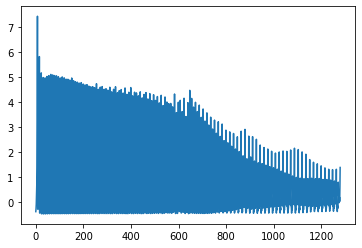

In [9]:
plt.plot(agent.loss_record)

In [10]:
torch.onnx.export(agent.policy.cpu(),
                  (torch.randn(1,state_dim)),
                  "checkpoint/PPO.onnx", 
                   export_params=True,        # 是否保存训练好的参数在网络中
                   opset_version=10,          # ONNX算子版本
                   do_constant_folding=True,  # 是否不保存常数输出（优化选项）
                   input_names = ['input'],   
                   output_names = ['fStickLat_shape', 'fStickLon_shape', 'fThrottle_shape', 'fRudder_shape',
                                   'eEleScanLine_shape', 'eAziScanRange', 'WeaponLaunch'])